In [1]:
# %%
# -------- 依赖导入 --------
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random, os

# 设随机种子，保证复现性
def set_all_seeds(seed: int = 1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_all_seeds(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# %%
# -------- 读取数据 --------
df = pd.read_csv(
    "data/household_power_consumption.txt", sep=";", low_memory=False
)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
# %%
# -------- 初步检查 --------
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
# %%
# -------- 清洗与预处理 --------
# 合并日期时间、去掉原列
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"],
                                format="%d/%m/%Y %H:%M:%S",
                                errors="coerce")
df.drop(["Date", "Time"], axis=1, inplace=True)

# 把 "?" 等非法值转换成 NaN，再整体转为 float
df.replace("?", np.nan, inplace=True)
for col in df.columns:
    if col != "datetime":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 去除缺失
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print("Start Date :", df["datetime"].min())
print("End Date   :", df["datetime"].max())


Start Date : 2006-12-16 17:24:00
End Date   : 2010-11-26 21:02:00


In [5]:
# %%
# -------- 按时间切分训练 / 测试集 --------
# 训练集：~2006-12-16 至 2009-12-31
# 测试集：2010-01-01 之后
train = df.loc[df["datetime"] <= "2009-12-31"].copy()
test  = df.loc[df["datetime"] >  "2009-12-31"].copy()

# 把 datetime 设置为索引，方便可视化或按需重采样
train.set_index("datetime", inplace=True)
test.set_index("datetime",  inplace=True)

In [6]:
# %%
# -------- 特征缩放 --------
scaler = MinMaxScaler()
# 仅用训练集拟合
train_scaled = scaler.fit_transform(train.values)
test_scaled  = scaler.transform(test.values)


In [7]:
# %%
# -------- 滑动窗口构造监督序列 --------
# 使用过去 60 条记录预测下一条记录的 Global_active_power （即第 0 列）
SEQ_LEN = 60  # 可以理解为“过去 60 分钟”

def split_X_y(array: np.ndarray, seq_len: int = SEQ_LEN, target_col: int = 0):
    """
    Parameters
    ----------
    array      : 2D np.ndarray, shape = (time_steps, n_features)
    seq_len    : 步长
    target_col : 目标列索引
    """
    X, y = [], []
    for i in range(seq_len, len(array)):
        X.append(array[i - seq_len : i, :])          # (seq_len, n_features)
        y.append(array[i, target_col])               # 预测目标
    return np.array(X), np.array(y)

train_X, train_y = split_X_y(train_scaled)
test_X,  test_y  = split_X_y(test_scaled)

print("Train X shape:", train_X.shape)  # (samples, seq_len, n_features)
print("Train y shape:", train_y.shape)

Train X shape: (1590387, 60, 7)
Train y shape: (1590387,)


In [8]:
# %%
# -------- 构建 DataLoader --------
BATCH_SIZE = 256

train_ds = TensorDataset(
    torch.FloatTensor(train_X),
    torch.FloatTensor(train_y),
)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = TensorDataset(
    torch.FloatTensor(test_X),
    torch.FloatTensor(test_y),
)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
# %%
# -------- 定义 LSTM 网络 --------
class LSTMModel(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int = 128,
                 num_layers: int = 1,
                 output_size: int = 1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x : (batch, seq_len, input_size)
        out, _ = self.lstm(x)              # 取最后时刻输出
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)              # (batch,)

INPUT_SIZE = train_X.shape[2]
model = LSTMModel(input_size=INPUT_SIZE).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(7, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [10]:
# %%
# -------- 训练 --------
EPOCHS = 2
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model.train()
    train_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_dl.dataset)

    # ---- validate (这里直接用 test_dl 监控，也可拆成验证集) ----
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss  = criterion(preds, yb)
            test_loss += loss.item() * xb.size(0)
    test_loss /= len(test_dl.dataset)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.6f} | "
              f"Test Loss: {test_loss:.6f}")

Epoch 001/2 | Train Loss: 0.000616 | Test Loss: 0.000377


In [11]:
# %%
# -------- 测试集推断 --------
model.eval()
with torch.no_grad():
    preds_test = []
    for xb, _ in test_dl:
        xb = xb.to(device)
        preds_test.append(model(xb).cpu().numpy())
preds_test = np.concatenate(preds_test, axis=0)  # (samples,)

# 反归一化 —— 只把目标列恢复到原量纲
# 1. 创建与 preds 同形状的全零矩阵
preds_full = np.zeros((preds_test.shape[0], train.values.shape[1]))
# 2. 把目标列填入
preds_full[:, 0] = preds_test
# 3. 用 scaler.inverse_transform 还原，然后再只取目标列
preds_denorm = scaler.inverse_transform(preds_full)[:, 0]

# 同理还原真实值
true_full = np.zeros_like(preds_full)
true_full[:, 0] = test_y
true_denorm = scaler.inverse_transform(true_full)[:, 0]

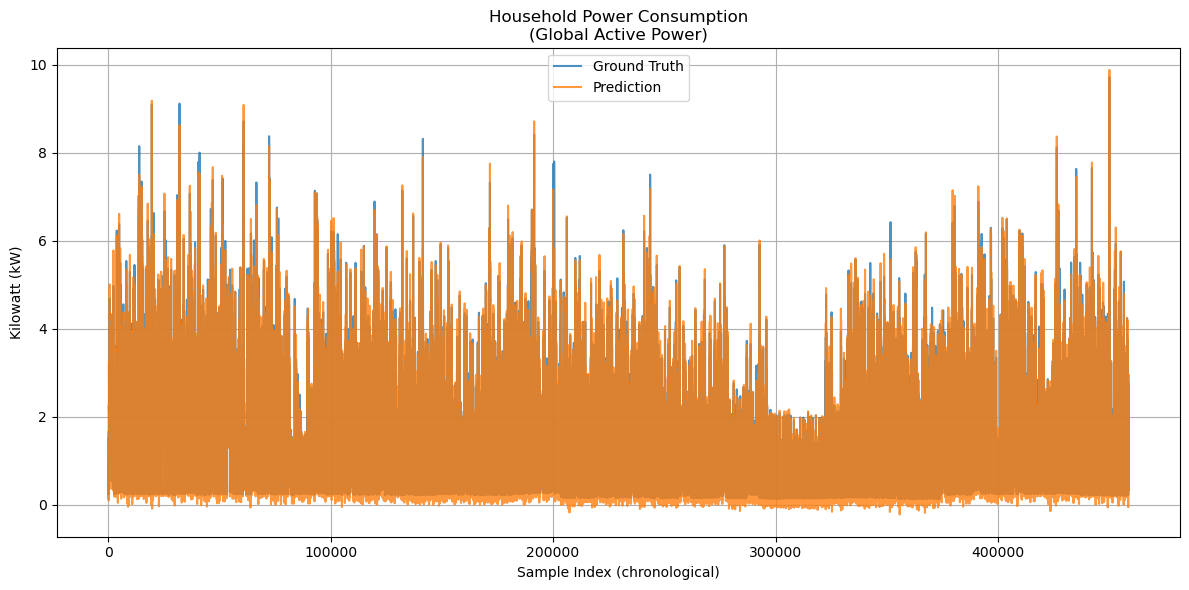

In [12]:
# %%
# -------- 可视化 --------
plt.figure(figsize=(12, 6))
plt.plot(true_denorm, label="Ground Truth", alpha=0.8)
plt.plot(preds_denorm, label="Prediction", alpha=0.8)
plt.title("Household Power Consumption\n(Global Active Power)")
plt.xlabel("Sample Index (chronological)")
plt.ylabel("Kilowatt (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

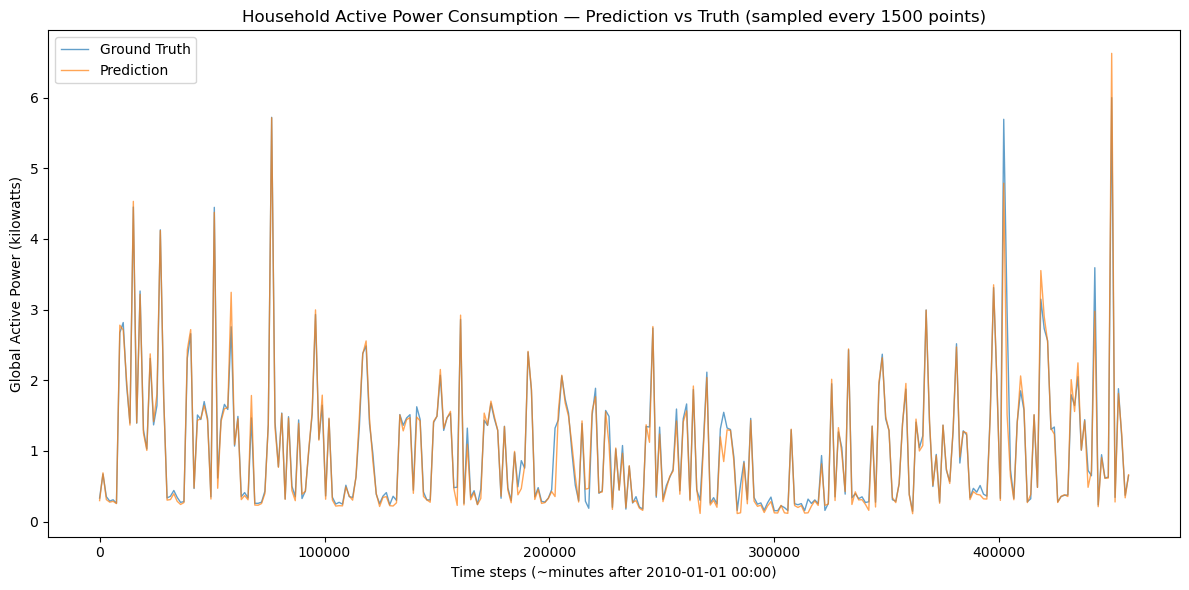

In [18]:
step = 1500  # 每隔step个点采样一个

indices = np.arange(0, len(true_denorm), step)

plt.figure(figsize=(12, 6))
plt.plot(indices, true_denorm[indices], label="Ground Truth", alpha=0.7, linewidth=1)
plt.plot(indices, preds_denorm[indices], label="Prediction", alpha=0.7, linewidth=1)


plt.title(f"Household Active Power Consumption — Prediction vs Truth (sampled every {step} points)")
plt.ylabel("Global Active Power (kilowatts)")
plt.xlabel("Time steps (~minutes after 2010‑01‑01 00:00)")
plt.legend()
plt.tight_layout()
plt.show()
